# Neural Networks - implementation from scratch 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# sklearn
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay


In [109]:
# np.random.seed(11111)

In [2]:
# fully - connected layer
class FCLayer:
    def __init__(self, input_size, output_size):
        self.input = None
        self.output = None
        # uniform distribution [0, 1] - 0.5 -> [-0.5, 0.5]
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        
    # forward propagation: 
    # compute output Y of the layer for a given input X
    def forward_propagation(self, input):
        if (np.ndim(input) == 1):
            self.input = input.reshape((1, input.shape[0]))
        else:
            self.input = input
            
        # Y = XW + B
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
        
    # backward propagation: 
    # compute dE/dW, dE/dB (update weights+bias) for a given output_error=dE/dY
    # return input_error=dE/dX
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        
        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        
        return input_error

In [3]:
# activation layer
class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.input = None
        self.output = None
        self.activation = activation
        self.activation_prime = activation_prime
    
    # forward propagation:
    # return the activated input (activation fcn applied on input)
    def forward_propagation(self, input_data):
        if (np.ndim(input_data) == 1):
            self.input = input_data.reshape((1, input_data.shape[0]))
        else:
            self.input = input_data
            
        self.output = self.activation(self.input)
        return self.output
    
    # backward propagation:
    # return input_error=dE/dX for a given output_error=dE/dY
    # learning_rate not used, there are no parameters to update
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

In [4]:
# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [5]:
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [55]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
        
    # add layer to the network
    def add(self, layer):
        self.layers.append(layer)
        
    # set loss function
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime
        
    # predict output for given input
    def predict(self, input_data):
        samples = len(input_data) # input size
        result = []
        
        # run network for all samples
        for i in range(0, samples):
            # forward propagation
            output = input_data[i, :] # i-th sample
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
            
        return result
    
    
    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train) # length of the training set
        err_vect = np.zeros(epochs)
        # training loop
        for i in range(0, epochs):
            err = 0
            for j in range(0, samples): # through all training samples
                # forward propagation
                output = x_train[j, :]  
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                    
                # compute loss
                err += self.loss(y_train[j], output)
                
                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)
            
            # average error per sample
            err /= samples
            err_vect[i] = err
            # print('epoch %d/%d   error=%f' % (i+1, epochs, err))
        return err_vect

    def fit_batch(self, x_train, y_train, epochs, learning_rate):
        samples = len(x_train) # length of the training set
        err_vect = np.zeros(epochs)
        # training loop
        for i in range(0, epochs):
            err = 0
            for j in range(0, samples): # through all training samples
                # forward propagation
                output = x_train[j, :]  
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                    
                # compute loss
                err += self.loss(y_train[j], output)
            
            # backward propagation - after all input samples have been propagated forwardly
            error = self.loss_prime(y_train, output)
            error = error.sum()
            for layer in reversed(self.layers):
                error = layer.backward_propagation(error, learning_rate)
            
            # average error per sample
            err /= samples
            err_vect[i] = err
            # print('epoch %d/%d   error=%f' % (i+1, epochs, err))
        return err_vect

    def plot_error_curve(self, err_vect):
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(err_vect)+1, 1), err_vect, '-', color='darkblue')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.title('Average error per sample through training epochs')
        
    def nn_evaluate(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        self.fit(x_train, y_train, epochs, learning_rate)
        
        y_train_pred = self.predict(x_train)
        y_train_pred = np.concatenate(y_train_pred).flatten()
        y_train_pred = np.round(y_train_pred).astype(int) # classification problem
        
        y_test_pred = self.predict(x_test)
        y_test_pred = np.concatenate(y_test_pred).flatten()
        y_test_pred = np.round(y_test_pred).astype(int)   # classification problem
        

        # accuracy
        print("#"*50)
        print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
        print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
        # recall
        print("#"*50)
        print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='micro'))
        print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average='micro'))
        # precision
        print("#"*50)
        print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='micro'))
        print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='micro'))
    
        # plot confusion matrices
        print("#"*50)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2'])
        cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
        ax[0].set_title("Confusion matrix: train data")

        c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2'])
        cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
        ax[1].set_title("Confusion matrix: test data")

        plt.tight_layout()
        plt.suptitle("Neural Network: our implementation", fontsize=15, ha='center')
        plt.subplots_adjust(top=0.85)

        plt.show()
        
    def nn_evaluate_one_hot(self, x_train, y_train, x_test, y_test, epochs, learning_rate):
        self.fit(x_train, y_train, epochs, learning_rate)
        
        y_train_pred = self.predict(X_train)
        y_train_pred = np.concatenate(y_train_pred)
        y_test_pred = self.predict(X_test)
        y_test_pred = np.concatenate(y_test_pred)
        
        # Convert one-hot encoded predictions back to class labels
        y_train_pred_labels = np.argmax(y_train_pred, axis=1)
        y_test_pred_labels = np.argmax(y_test_pred, axis=1)

        # Convert one-hot encoded true labels back to class labels
        y_train_labels = np.argmax(y_train, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)
    

        # accuracy
        print("#"*50)
        print("Accuracy on train: ", accuracy_score(y_true=y_train_labels, y_pred=y_train_pred_labels))
        print("Accuracy on test: ", accuracy_score(y_true=y_test_labels, y_pred=y_test_pred_labels))
        # recall
        print("#"*50)
        print("Recall on train: ", recall_score(y_true=y_train_labels, y_pred=y_train_pred_labels, average='micro'))
        print("Recall on test: ", recall_score(y_true=y_test_labels, y_pred=y_test_pred_labels, average='micro'))
        # precision
        print("#"*50)
        print("Precision on train: ", precision_score(y_true=y_train_labels, y_pred=y_train_pred_labels, average='micro'))
        print("Precision on test: ", precision_score(y_true=y_test_labels, y_pred=y_test_pred_labels, average='micro'))
    
        # plot confusion matrices
        print("#"*50)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

        c_1 = confusion_matrix(y_true=y_train_labels, y_pred=y_train_pred_labels)
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2'])
        cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
        ax[0].set_title("Confusion matrix: train data")

        c_2 = confusion_matrix(y_true=y_test_labels, y_pred=y_test_pred_labels)
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2'])
        cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
        ax[1].set_title("Confusion matrix: test data")

        plt.tight_layout()
        plt.suptitle("Neural Network: our implementation", fontsize=15, ha='center')
        plt.subplots_adjust(top=0.85)

        plt.show()
        
        

### Example

In [7]:
# building NN

# training data
# x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
# y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

x_train = np.array([[0,0], [0,1], [1,0], [1,1]])
y_train = np.array([[0], [1], [1], [0]])
x_train

array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]])

In [8]:
y_train[1, :] = y_train[1, :].reshape((1, 1))
y_train[1, :].shape

(1,)

[array([[0.00063101]]), array([[-0.00085216]]), array([[0.97923585]]), array([[0.00024476]])]


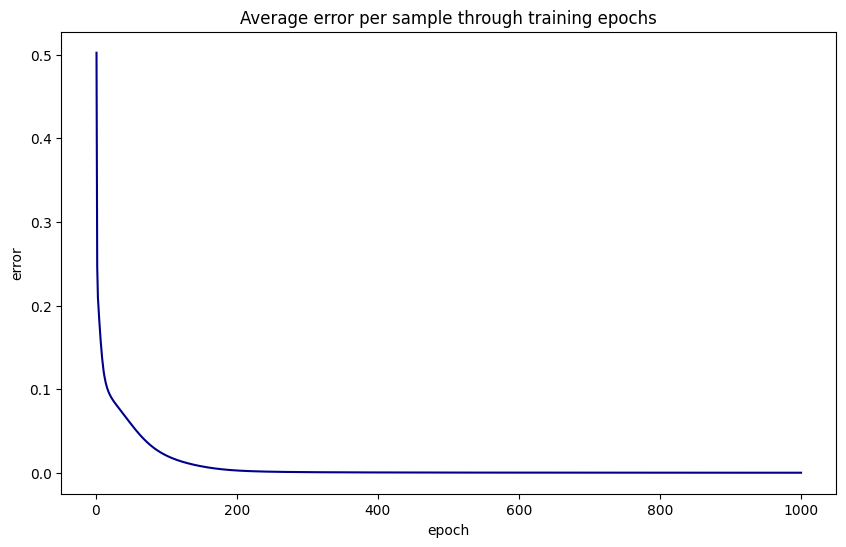

In [105]:
# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
err_vect = net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)
net.plot_error_curve(err_vect)

# test
out = net.predict(x_train)
print(out)

In [45]:
np.concatenate(out).flatten()

array([ 1.04038937e-03,  9.77777823e-01,  9.78003587e-01, -2.09957081e-04])

In [46]:
# Conversion to 1D numpy array
print(out)
print(np.concatenate(out))
print(np.concatenate(out).flatten())

[array([[0.00104039]]), array([[0.97777782]]), array([[0.97800359]]), array([[-0.00020996]])]
[[ 1.04038937e-03]
 [ 9.77777823e-01]
 [ 9.78003587e-01]
 [-2.09957081e-04]]
[ 1.04038937e-03  9.77777823e-01  9.78003587e-01 -2.09957081e-04]


In [47]:
# net.nn_evaluate(x_train=x_train, y_train=y_train, x_test=x_train, y_test=y_train, epochs=1000, learning_rate=0.1)

### Example: Iris dataset

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)


In [10]:
print(X_train.shape)
print(X_test.shape)

(120, 4)
(30, 4)


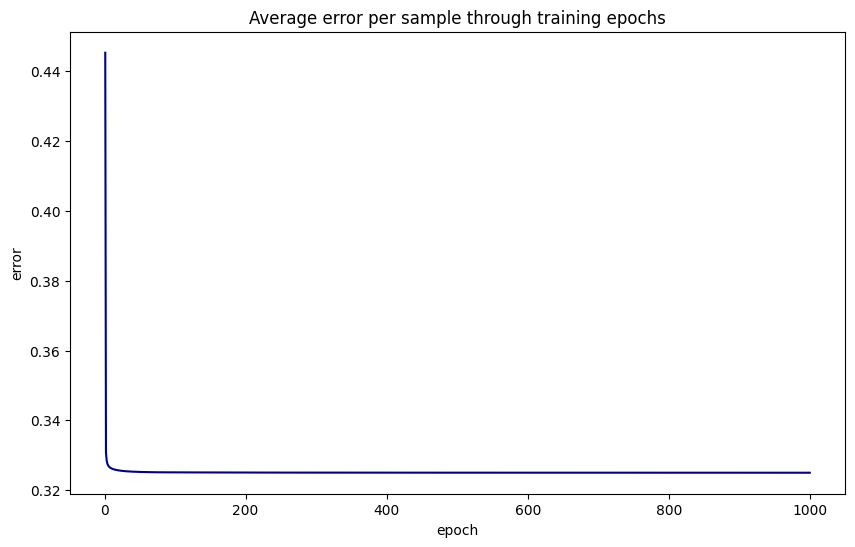

In [115]:
# network
# np.random.seed(11111)
net = Network()
net.add(FCLayer(4, 5))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
# reshape first, such that every row becomes separate array
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# y_train = y_train.reshape(y_train.shape[0], 1, 1)

# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# y_test = y_test.reshape(y_test.shape[0], 1, 1)

err_vect = net.fit(X_train, y_train, epochs=1000, learning_rate=0.1)
net.plot_error_curve(err_vect)

##################################################
Accuracy on train:  0.675
Accuracy on test:  0.6333333333333333
##################################################
Recall on train:  0.675
Recall on test:  0.6333333333333333
##################################################
Precision on train:  0.675
Precision on test:  0.6333333333333333
##################################################


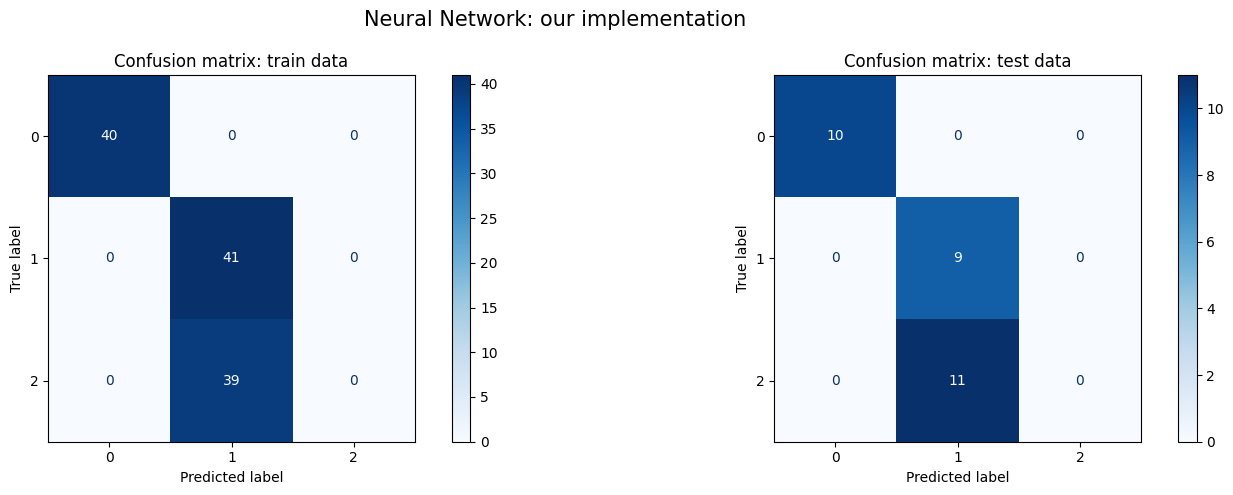

In [58]:
net.nn_evaluate(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=1000, learning_rate=0.1)

### 1-hot-encoding

In [33]:
# Encoded values
from sklearn.preprocessing import OneHotEncoder
iris = load_iris()
X = iris.data
y = iris.target

encoder = OneHotEncoder(sparse = False)
y_reshaped = y.reshape(-1,1)
y_encoded = encoder.fit_transform(y_reshaped)

X_train, X_test, y_train, y_test = train_test_split(iris.data, y_encoded, test_size=0.2, random_state=42)

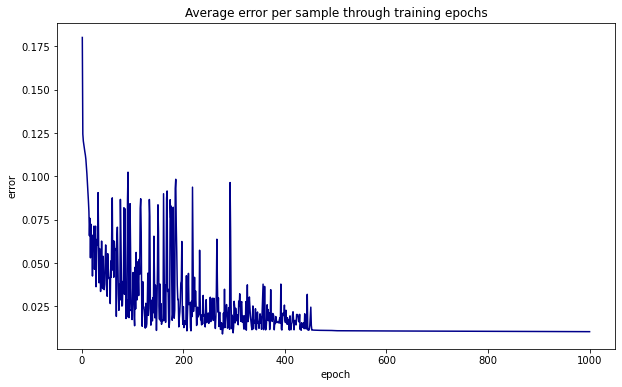

In [34]:
# network
net = Network()
net.add(FCLayer(4, 5))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 3))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)

err_vect = net.fit(X_train, y_train, epochs=1000, learning_rate=0.1)
net.plot_error_curve(err_vect)

##################################################
Accuracy on train:  0.9833333333333333
Accuracy on test:  0.9666666666666667
##################################################
Recall on train:  0.9833333333333333
Recall on test:  0.9666666666666667
##################################################
Precision on train:  0.9833333333333333
Precision on test:  0.9666666666666667
##################################################


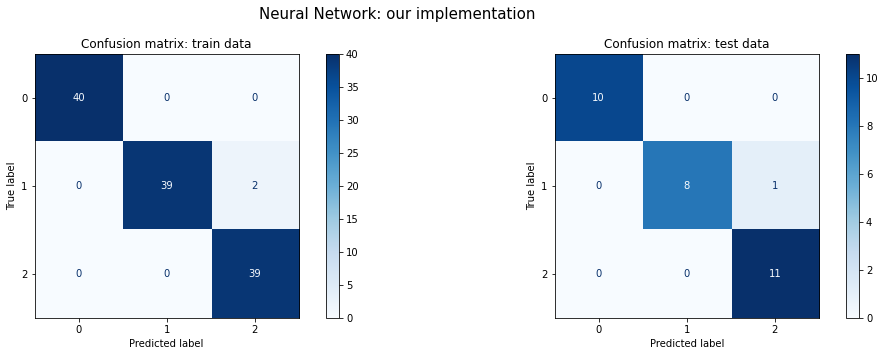

In [35]:
net.nn_evaluate_one_hot(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=1000, learning_rate=0.1)

### Batch approach
Until now incremental approach was performed and weights were updated after every training sample. Let's propagate whole training set now and after that update the weights

In [56]:
# Encoded values
from sklearn.preprocessing import OneHotEncoder
iris = load_iris()
X = iris.data
y = iris.target

encoder = OneHotEncoder(sparse = False)
y_reshaped = y.reshape(-1,1)
y_encoded = encoder.fit_transform(y_reshaped)

X_train, X_test, y_train, y_test = train_test_split(iris.data, y_encoded, test_size=0.2, random_state=42)

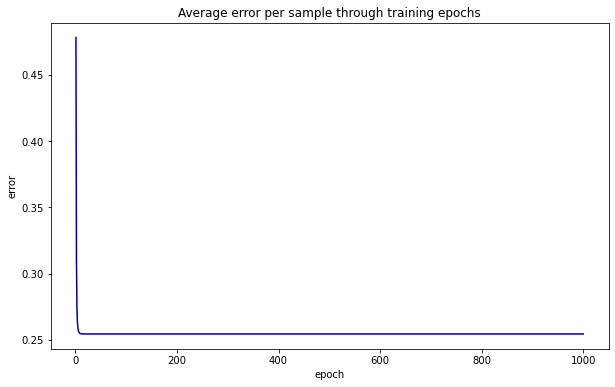

In [63]:
# network
net = Network()
net.add(FCLayer(4, 5))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(5, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 3))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)

err_vect = net.fit_batch(X_train, y_train, epochs=1000, learning_rate=0.1)
net.plot_error_curve(err_vect)

##################################################
Accuracy on train:  0.3416666666666667
Accuracy on test:  0.3
##################################################
Recall on train:  0.3416666666666667
Recall on test:  0.3
##################################################
Precision on train:  0.3416666666666667
Precision on test:  0.3
##################################################


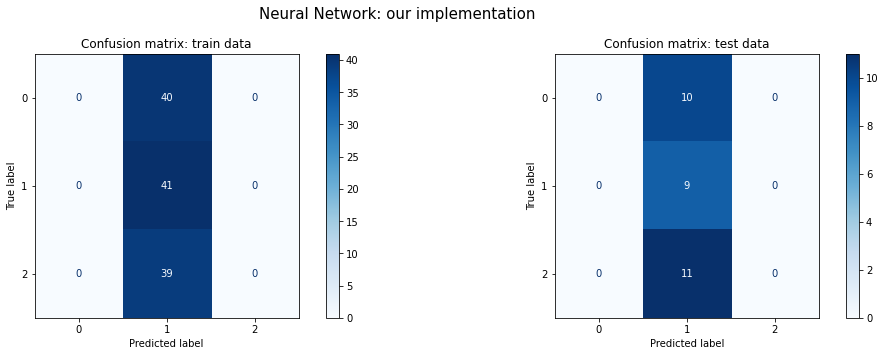

In [64]:
# change in class Network nn_evaluate_one_hot self.fit -> self.fit_bach
# Since the results are not satisfactory here, we'll continue with incremental approach, so that change 
# in class method was deleted
# net.nn_evaluate_one_hot(x_train=X_train, y_train=y_train, x_test=X_test, y_test=y_test, epochs=1000, learning_rate=0.1)

Maybe to try with propagating batch_size of samples, and then updating weights (not whole training set)?
To be continued...

### The impact of initial random weightening

In [65]:
# Encoded values
from sklearn.preprocessing import OneHotEncoder
iris = load_iris()
X = iris.data
y = iris.target

encoder = OneHotEncoder(sparse = False)
y_reshaped = y.reshape(-1,1)
y_encoded = encoder.fit_transform(y_reshaped)

X_train, X_test, y_train, y_test = train_test_split(iris.data, y_encoded, test_size=0.2, random_state=42)

0
1
2
3


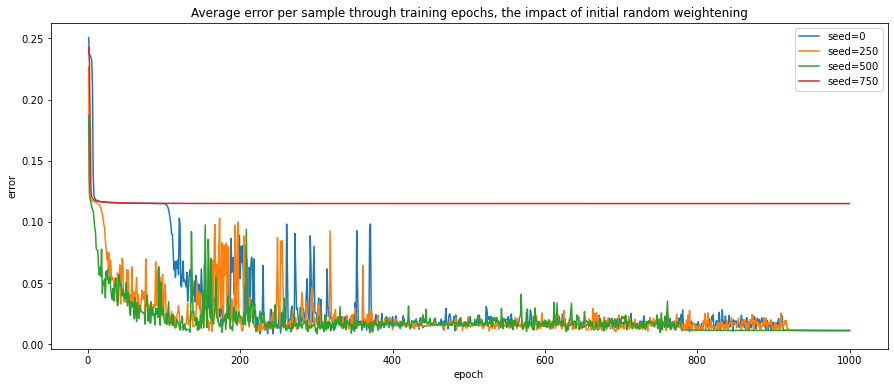

In [74]:
k = 4
plt.figure(figsize=(15, 6))
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Average error per sample through training epochs, the impact of initial random weightening')

for i in range(0, k):
    np.random.seed(i*250)
    print(i)
    net = Network()
    net.add(FCLayer(4, 5))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(5, 3))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(3, 3))
    net.add(ActivationLayer(tanh, tanh_prime))
    net.add(FCLayer(3, 3))
    net.add(ActivationLayer(tanh, tanh_prime))

    # train
    net.use(mse, mse_prime)
    err_vect = net.fit(X_train, y_train, epochs=1000, learning_rate=0.1)
    
    plt.plot(np.arange(1, len(err_vect)+1, 1), err_vect, '-', label='seed='+str(i*250))
plt.legend()
plt.show()



In [117]:
## cross entropy
#another option for loss function
def categorical_cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))


def categorical_cross_entropy_prime(y_true, y_pred):
    return y_pred - y_true

In [116]:
### sigmoid

def sigmoid(x):
    g = np.frompyfunc(lambda t: (1+np.exp(-t)),1,1)
    return g(x).astype(x.dtype)

def sigmoidGradient(x):
    return sigmoid(x) * (1-sigmoid(x))
    